# Evolution of neural networks robust to adversarial examples

# Setup

In [10]:
%matplotlib inline 

import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D

from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import KerasModelWrapper

from IPython.display import SVG

In [ ]:
import warnings
from distutils.version import LooseVersion
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from .model import Model

if LooseVersion(keras.__version__) >= LooseVersion('2.0.0'):
    from keras.layers import Conv2D
else:
    from keras.layers import Convolution2D

In [2]:
#hyperparams
train_start=0
train_end=60000
test_start=0
test_end=10000
nb_epochs=6
batch_size=128
learning_rate=0.001
train_dir=r"D:\Models\Adversarial"
filename="mnist.ckpt"
load_model=True
testing=False

In [3]:
keras.layers.core.K.set_learning_phase(0)
report = AccuracyReport()
tf.set_random_seed(1234)
sess = tf.Session()
K.set_session(sess)

In [4]:
# Get MNIST test data
X_train, Y_train, X_test, Y_test = data_mnist(train_start=train_start,
                                              train_end=train_end,
                                              test_start=test_start,
                                              test_end=test_end)

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [5]:
# Use label smoothing
assert Y_train.shape[1] == 10
label_smooth = .1
Y_train = Y_train.clip(label_smooth / 9., 1. - label_smooth)

In [6]:
# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

In [13]:
def conv_2d(filters, kernel_shape, strides, padding, input_shape=None):
    """
    :param filters: (required integer) the dimensionality of the output
                    space (i.e. the number output of filters in the
                    convolution)
    :param kernel_shape: (required tuple or list of 2 integers) specifies
                         the strides of the convolution along the width and
                         height.
    :param padding: (required string) can be either 'valid' (no padding around
                    input or feature map) or 'same' (pad to ensure that the
                    output feature map size is identical to the layer input)
    :param input_shape: (optional) give input shape if this is the first
                        layer of the model
    :return: the Keras layer
    """
    
    if input_shape is not None:
        return Conv2D(filters=filters, kernel_size=kernel_shape,
                      strides=strides, padding=padding,
                      input_shape=input_shape)
    else:
        return Conv2D(filters=filters, kernel_size=kernel_shape,
                      strides=strides, padding=padding)


In [14]:
def cnn_model(logits=False, input_ph=None, img_rows=28, img_cols=28,
              channels=1, nb_filters=64, nb_classes=10):
    """
    Defines a CNN model using Keras sequential model
    :param logits: If set to False, returns a Keras model, otherwise will also
                    return logits tensor
    :param input_ph: The TensorFlow tensor for the input
                    (needed if returning logits)
                    ("ph" stands for placeholder but it need not actually be a
                    placeholder)
    :param img_rows: number of row in the image
    :param img_cols: number of columns in the image
    :param channels: number of color channels (e.g., 1 for MNIST)
    :param nb_filters: number of convolutional filters per layer
    :param nb_classes: the number of output classes
    :return:
    """
    model = Sequential()

    # Define the layers successively (convolution layers are version dependent)
    if K.image_dim_ordering() == 'th':
        input_shape = (channels, img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, channels)

    layers = [conv_2d(nb_filters, (8, 8), (2, 2), "same",
                      input_shape=input_shape),
              Activation('relu'),
              conv_2d((nb_filters * 2), (6, 6), (2, 2), "valid"),
              Activation('relu'),
              conv_2d((nb_filters * 2), (5, 5), (1, 1), "valid"),
              Activation('relu'),
              Flatten(),
              Dense(nb_classes)]

    for layer in layers:
        model.add(layer)

    if logits:
        logits_tensor = model(input_ph)
    model.add(Activation('softmax'))

    if logits:
        return model, logits_tensor
    else:
        return model

In [15]:
# Define TF model graph
model = cnn_model()
preds = model(x)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         295040    
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         409728    
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

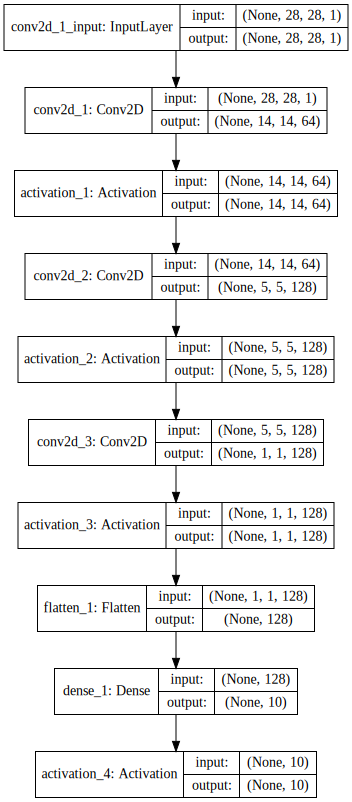

In [17]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [18]:
def evaluate():
    # Evaluate the accuracy of the MNIST model on legitimate test examples
    eval_params = {'batch_size': batch_size}
    acc = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
    report.clean_train_clean_eval = acc
    assert X_test.shape[0] == test_end - test_start, X_test.shape
    print('Test accuracy on legitimate examples: %0.4f' % acc)

# Train 

In [19]:
# Train an MNIST model
train_params = {
    'nb_epochs': nb_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'train_dir': train_dir,
    'filename': filename
}
ckpt = tf.train.get_checkpoint_state(train_dir)
ckpt_path = False if ckpt is None else ckpt.model_checkpoint_path

rng = np.random.RandomState([2017, 8, 30]) #for shuffling training set

if load_model and ckpt_path:
    saver = tf.train.Saver()
    saver.restore(sess, ckpt_path)
    print("Model loaded from: {}".format(ckpt_path))
    evaluate()
else:
    print("Model was not loaded, training from scratch.")
    model_train(sess, x, y, preds, X_train, Y_train, evaluate=evaluate,
                args=train_params, save=True, rng=rng)

INFO:tensorflow:Restoring parameters from D:\Models\Adversarial\mnist.ckpt
Model loaded from: D:\Models\Adversarial\mnist.ckpt
Test accuracy on legitimate examples: 0.9934


In [23]:
# Calculate training error
eval_params = {'batch_size': batch_size}
acc = model_eval(sess, x, y, preds, X_train, Y_train, args=eval_params)
report.train_clean_train_clean_eval = acc

print(acc)

0.9994


# FGSM 

In [25]:
# Initialize the Fast Gradient Sign Method (FGSM) attack object and graph
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
               'clip_min': 0.,
               'clip_max': 1.}
adv_x = fgsm.generate(x, **fgsm_params);

In [26]:
# Consider the attack to be constant
adv_x = tf.stop_gradient(adv_x)
preds_adv = model(adv_x)

In [46]:
def adv_plotter(index, X_train, fgsm_params, model):
    
    img = X_train[index]
    shape = img.shape
    imgr = img.reshape(1, shape[0], shape[1], 1)
    adversarial = fgsm.generate_np(imgr, **fgsm_params)
    
    clean_pred = model.predict(imgr)
    clean_perct = np.max(clean_pred)
    clean_class = np.argmax(clean_pred)
    
    adv_pred = model.predict(adversarial)
    adv_perct = np.max(adv_pred)
    adv_class = np.argmax(adv_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(img.reshape(28,28), cmap='Greys')
    ax1.text(x=2, y=32, s="Predicted: {x:.0f} ({y:.2f})".format(x=clean_class, y=clean_perct), fontsize=20)
    ax2.imshow(adversarial.reshape(28,28), cmap='Greys')
    ax2.text(x=2, y=32, s="Predicted: {x:.0f} ({y:.2f})".format(x=adv_class, y=adv_perct), fontsize=20)

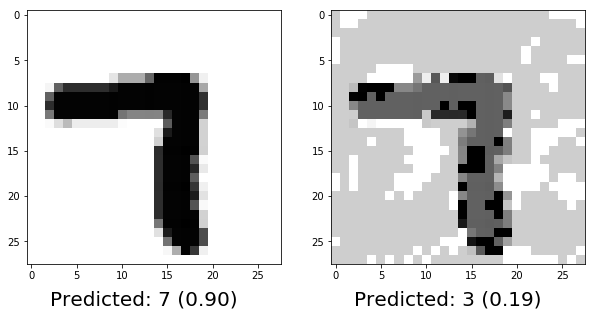

In [47]:
ad = adv_plotter(9111, X_train, fgsm_params, model)

In [51]:
wrap._get_softmax_name()

'activation_4'

In [ ]:
def visualize_class_activation_map(model_path, img_path, output_path):
    
        
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        for i, w in enumerate(class_weights[:, 1]):
                cam += w * conv_outputs[i, :, :]
        print "predictions", predictions
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        img = heatmap*0.5 + original_img
        cv2.imwrite(output_path, img)

In [53]:
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [54]:
final_conv_layer = get_output_layer(model, "conv2d_3")

In [ ]:
grads = K.gradients(four_output, last_conv_layer.output)[0]
#pooled_grads = K.mean(grads, axis=(0, 1, 2))
#iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

iterate = K.function([model.get_input_at(0)], [grads, last_conv_layer.output[0]])

In [ ]:
# Evaluate the accuracy of the MNIST model on adversarial examples
eval_par = {'batch_size': batch_size}
acc = model_eval(sess, x, y, preds_adv, X_test, Y_test, args=eval_par)
print('Test accuracy on adversarial examples: %0.4f\n' % acc)
report.clean_train_adv_eval = acc

In [ ]:
# Calculating train error
if testing:
    eval_par = {'batch_size': batch_size}
    acc = model_eval(sess, x, y, preds_adv, X_train,
                     Y_train, args=eval_par)
    report.train_clean_train_adv_eval = acc

In [ ]:
# Redefine TF model graph
model_2 = cnn_model()
preds_2 = model_2(x)
wrap_2 = KerasModelWrapper(model_2)
fgsm2 = FastGradientMethod(wrap_2, sess=sess)
preds_2_adv = model_2(fgsm2.generate(x, **fgsm_params))

In [ ]:
def evaluate_2():
    # Accuracy of adversarially trained model on legitimate test inputs
    eval_params = {'batch_size': batch_size}
    accuracy = model_eval(sess, x, y, preds_2, X_test, Y_test,
                          args=eval_params)
    print('Test accuracy on legitimate examples: %0.4f' % accuracy)
    report.adv_train_clean_eval = accuracy

    # Accuracy of the adversarially trained model on adversarial examples
    accuracy = model_eval(sess, x, y, preds_2_adv, X_test,
                          Y_test, args=eval_params)
    print('Test accuracy on adversarial examples: %0.4f' % accuracy)
    report.adv_train_adv_eval = accuracy

In [ ]:
# Perform and evaluate adversarial training
model_train(sess, x, y, preds_2, X_train, Y_train,
            predictions_adv=preds_2_adv, evaluate=evaluate_2,
            args=train_params, save=False, rng=rng)

In [ ]:
# Calculate training errors

eval_params = {'batch_size': batch_size}
accuracy = model_eval(sess, x, y, preds_2, X_train, Y_train,
                      args=eval_params)
report.train_adv_train_clean_eval = accuracy
accuracy = model_eval(sess, x, y, preds_2_adv, X_train,
                      Y_train, args=eval_params)
report.train_adv_train_adv_eval = accuracy

In [ ]:
report.__dict__